In [72]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/graduate-employability-dataset/CollegePlacement.csv


In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif, RFE, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc
from xgboost import XGBClassifier
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
import shap

import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading and Inspection

In [74]:
df = pd.read_csv('/kaggle/input/graduate-employability-dataset/CollegePlacement.csv')
df.head()

,College_ID,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Internship_Experience,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Placement
0,CLG0030,107,6.61,6.28,8,No,8,8,4,No
1,CLG0061,97,5.52,5.37,8,No,7,8,0,No
2,CLG0036,109,5.36,5.83,9,No,3,1,1,No
3,CLG0055,122,5.47,5.75,6,Yes,1,6,1,No
4,CLG0004,96,7.91,7.69,7,No,8,10,2,No


In [75]:
print("Dataset Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:n", df.isnull().sum())

Dataset Shape: (10000, 10)

Data Types:
 College_ID                 object
IQ                          int64
Prev_Sem_Result           float64
CGPA                      float64
Academic_Performance        int64
Internship_Experience      object
Extra_Curricular_Score      int64
Communication_Skills        int64
Projects_Completed          int64
Placement                  object
dtype: object

Missing Values:n College_ID                0
IQ                        0
Prev_Sem_Result           0
CGPA                      0
Academic_Performance      0
Internship_Experience     0
Extra_Curricular_Score    0
Communication_Skills      0
Projects_Completed        0
Placement                 0
dtype: int64


In [76]:
print("\nSummary Statistics:\n", df.describe())


Summary Statistics:
                  IQ  Prev_Sem_Result          CGPA  Academic_Performance  \
count  10000.000000     10000.000000  10000.000000          10000.000000   
mean      99.471800         7.535673      7.532379              5.546400   
std       15.053101         1.447519      1.470141              2.873477   
min       41.000000         5.000000      4.540000              1.000000   
25%       89.000000         6.290000      6.290000              3.000000   
50%       99.000000         7.560000      7.550000              6.000000   
75%      110.000000         8.790000      8.770000              8.000000   
max      158.000000        10.000000     10.460000             10.000000   

       Extra_Curricular_Score  Communication_Skills  Projects_Completed  
count            10000.000000          10000.000000        10000.000000  
mean                 4.970900              5.561800            2.513400  
std                  3.160103              2.900866            1.715959

In [77]:
print("\nNo. of Duplicated Rows:\n", df.duplicated().sum())


No. of Duplicated Rows:
 0


In [78]:
categorical_cols = ['Internship_Experience', 'Placement']
for col in categorical_cols:
    print(f"\nUnique Values in {col}:\n", df[col].unique())
    print(f"\nValue Counts in {col}:\n", df[col].value_counts())


Unique Values in Internship_Experience:
 ['No' 'Yes']

Value Counts in Internship_Experience:
 Internship_Experience
No     6036
Yes    3964
Name: count, dtype: int64

Unique Values in Placement:
 ['No' 'Yes']

Value Counts in Placement:
 Placement
No     8341
Yes    1659
Name: count, dtype: int64


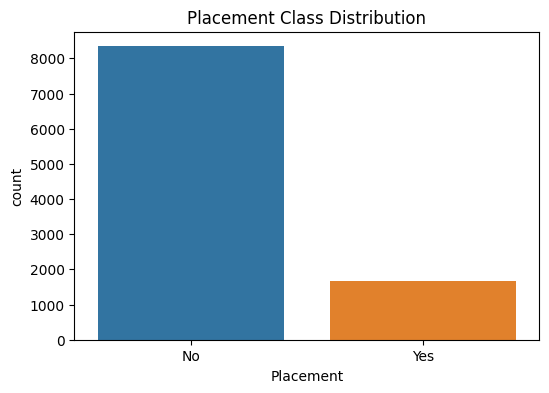

In [79]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Placement', data=df)
plt.title('Placement Class Distribution')
plt.show()

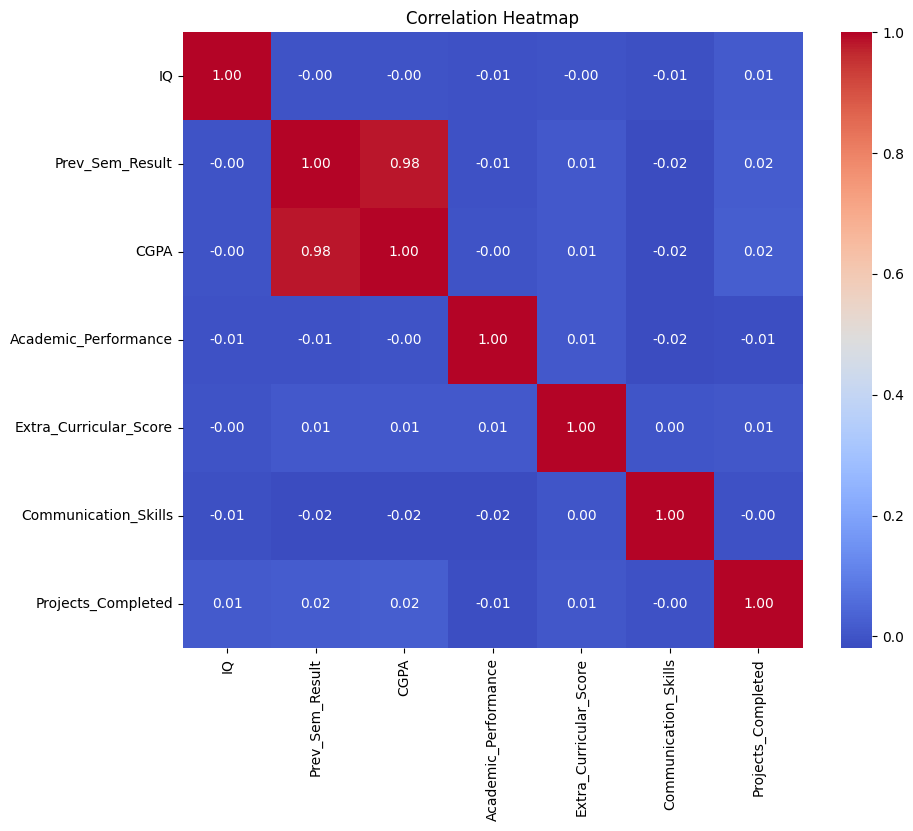

In [80]:
numerical_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## 2. EDA

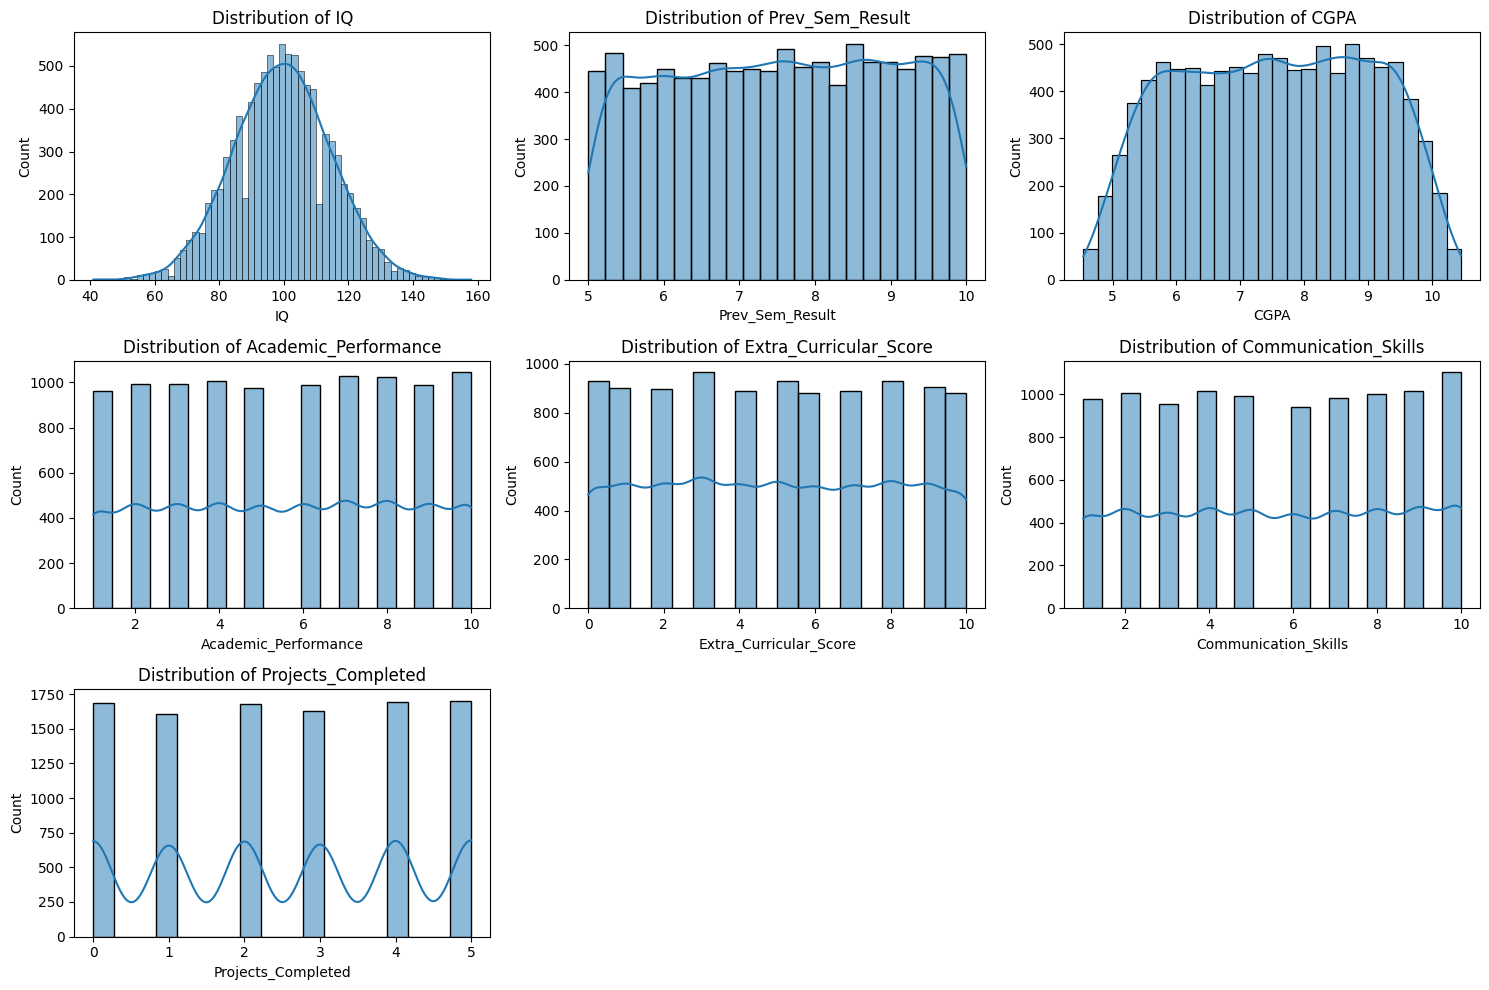

In [81]:
numerical_cols = ['IQ', 'Prev_Sem_Result', 'CGPA', 'Academic_Performance', 
                  'Extra_Curricular_Score', 'Communication_Skills', 'Projects_Completed']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

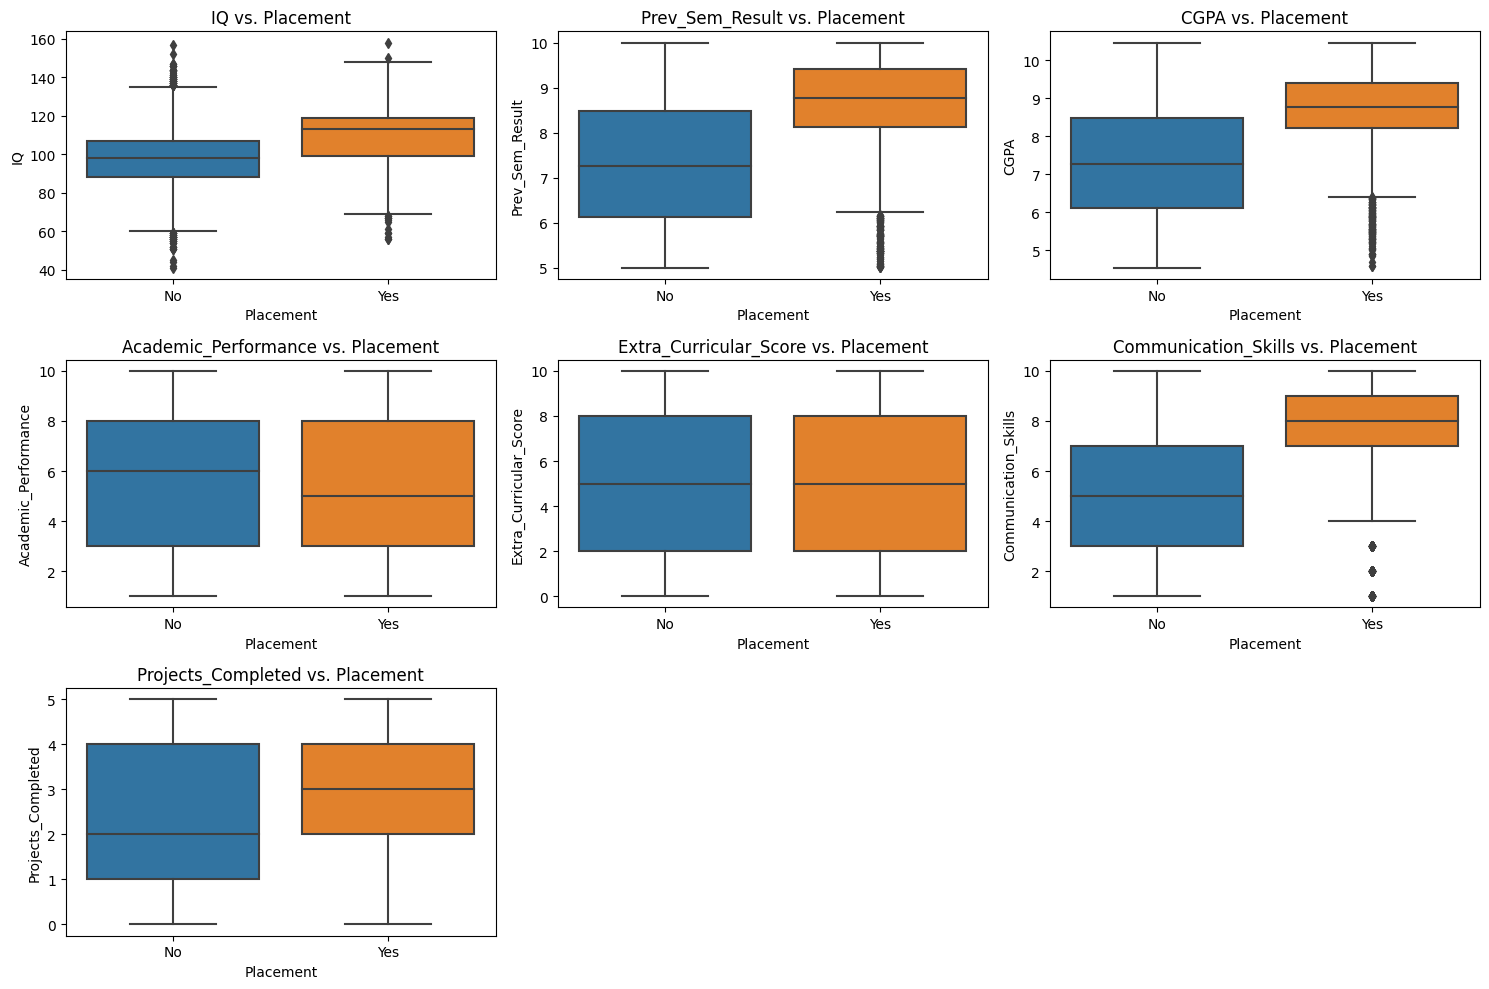

In [82]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='Placement', y=col, data=df)
    plt.title(f'{col} vs. Placement')
plt.tight_layout()
plt.show()

**Boxplot Observations**

- **IQ:** Minimal difference between No (median 99) and Yes (median 102), similar IQR, outliers in Yes up to 160, weak separation but positive trend.
- **Prev_Sem_Result and CGPA:** Clear separation Yes has higher medians and IQRs shifted right, fewer low outliers in Yes, means academic metrics are strong predictors.
- **Academic_Performance:** Higher median in Yes, overlapping IQRs and outliers signify moderate separability; potential for binning into categories.
- **Extra_Curricular_Score:** Slight elevation in 'Yes' (median ~5.5 vs. ~5), with symmetric whiskers but high overlap, suggesting limited predictive power.
- **Communication_Skills:** Strongest separation among skills Yes median 8 (IQR 6-10) vs. No 5 (IQR 3-8), with Yes having tighter distribution and fewer low outliers, so it is as a key differentiator.
- **Projects_Completed:** Higher in Yes , with IQR 2-4 vs. 1-3, and no high outliers in No, means practical experience correlates with placement.

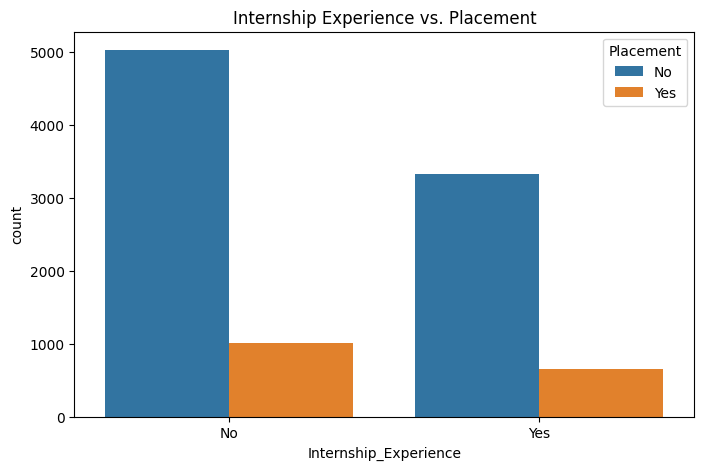

In [83]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Internship_Experience', hue='Placement', data=df)
plt.title('Internship Experience vs. Placement')
plt.show()

In [84]:
print("\nCrosstab: Internship_Experience vs. Placement\n", pd.crosstab(df['Internship_Experience'], df['Placement'], normalize='index'))


Crosstab: Internship_Experience vs. Placement
 Placement                    No       Yes
Internship_Experience                    
No                     0.832339  0.167661
Yes                    0.836781  0.163219


In [85]:
df_temp = df.copy()
df_temp['Placement'] = df_temp['Placement'].map({'No': 0, 'Yes': 1})
print("\nCorrelation with Placement:\n", df_temp[numerical_cols + ['Placement']].corr()['Placement'].sort_values(ascending=False))


Correlation with Placement:
 Placement                 1.000000
Communication_Skills      0.323155
CGPA                      0.321607
Prev_Sem_Result           0.317896
IQ                        0.285914
Projects_Completed        0.217499
Extra_Curricular_Score   -0.004740
Academic_Performance     -0.014920
Name: Placement, dtype: float64


## 3. Preprocessing

In [86]:
df_processed = df.drop(['College_ID', 'Prev_Sem_Result'], axis=1)

In [87]:
le_intern = LabelEncoder()
df_processed['Internship_Experience'] = le_intern.fit_transform(df_processed['Internship_Experience'])

le_place = LabelEncoder()
y = le_place.fit_transform(df_processed['Placement'])  # No=0, Yes=1
X = df_processed.drop('Placement', axis=1)

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [89]:
scaler = StandardScaler()
numerical_cols_to_scale = ['IQ', 'CGPA', 'Academic_Performance', 'Extra_Curricular_Score', 
                           'Communication_Skills', 'Projects_Completed']
X_train[numerical_cols_to_scale] = scaler.fit_transform(X_train[numerical_cols_to_scale])
X_test[numerical_cols_to_scale] = scaler.transform(X_test[numerical_cols_to_scale])

## 4. Feature Engineering 

In [90]:
# Interaction terms
X_train['CGPA_Comm_Interaction'] = X_train['CGPA'] * X_train['Communication_Skills']

In [91]:
X_train['CGPA_Bin'] = pd.cut(X_train['CGPA'], bins=3, labels=[0, 1, 2], include_lowest=True)
X_train['CGPA_Bin'] = X_train['CGPA_Bin'].astype(int)  # Encode as 0/1/2

X_train['Overall_Skills'] = (X_train['Communication_Skills'] + X_train['Extra_Curricular_Score'] + 
                             X_train['Projects_Completed']) / 3  # Average for interpretability

In [92]:
X_test['CGPA_Comm_Interaction'] = X_test['CGPA'] * X_test['Communication_Skills']
X_test['CGPA_Bin'] = pd.cut(X_test['CGPA'], bins=3, labels=[0, 1, 2], include_lowest=True)
X_test['CGPA_Bin'] = X_test['CGPA_Bin'].astype(int)
X_test['Overall_Skills'] = (X_test['Communication_Skills'] + X_test['Extra_Curricular_Score'] + 
                            X_test['Projects_Completed']) / 3

In [93]:
mi_selector = SelectKBest(score_func=mutual_info_classif, k=7)
X_train_mi = mi_selector.fit_transform(X_train, y_train)
X_test_mi = mi_selector.transform(X_test)

In [94]:
mi_scores = pd.DataFrame({
    'feature': X_train.columns,
    'mi_score': mi_selector.scores_
}).sort_values('mi_score', ascending=False)
print("\nMutual Information Scores:\n", mi_scores)


Mutual Information Scores:
                   feature  mi_score
9          Overall_Skills  0.133607
5    Communication_Skills  0.077296
1                    CGPA  0.068425
0                      IQ  0.064099
7   CGPA_Comm_Interaction  0.058010
6      Projects_Completed  0.043655
8                CGPA_Bin  0.042738
2    Academic_Performance  0.000000
3   Internship_Experience  0.000000
4  Extra_Curricular_Score  0.000000


In [95]:
lr = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
rfe = RFE(estimator=lr, n_features_to_select=7)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

In [96]:
# RFE support/mask
rfe_support = pd.DataFrame({
    'feature': X_train.columns,
    'selected': rfe.support_
}).sort_values('selected', ascending=False)
print("\nRFE Selected Features:\n", rfe_support)


RFE Selected Features:
                   feature  selected
0                      IQ      True
1                    CGPA      True
4  Extra_Curricular_Score      True
5    Communication_Skills      True
6      Projects_Completed      True
7   CGPA_Comm_Interaction      True
9          Overall_Skills      True
2    Academic_Performance     False
3   Internship_Experience     False
8                CGPA_Bin     False


## 5. Model Selection

In [97]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100)
}

In [98]:
cv_results = {}
for name, model in models.items():
    cv_f1 = cross_val_score(model, X_train_mi, y_train, cv=5, scoring='f1')
    cv_auc = cross_val_score(model, X_train_mi, y_train, cv=5, scoring='roc_auc')
    cv_results[name] = {'CV F1 Mean': np.mean(cv_f1), 'CV F1 Std': np.std(cv_f1),
                        'CV AUC Mean': np.mean(cv_auc), 'CV AUC Std': np.std(cv_auc)}
print("Cross-Validation Results:\n", pd.DataFrame(cv_results).T)

Cross-Validation Results:
                      CV F1 Mean  CV F1 Std  CV AUC Mean  CV AUC Std
Logistic Regression    0.659213   0.020018     0.939690    0.008111
Decision Tree          0.999623   0.000753     0.999624    0.000752
Random Forest          0.998489   0.001412     0.999999    0.000001


In [99]:
test_results = {}
for name, model in models.items():
    model.fit(X_train_mi, y_train)
    y_pred = model.predict(X_test_mi)
    y_pred_proba = model.predict_proba(X_test_mi)[:, 1] if hasattr(model, 'predict_proba') else None
    
    test_results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    }

print("\nTest Set Results:\n", pd.DataFrame(test_results).T.round(4))


Test Set Results:
                      Accuracy  Precision  Recall      F1     AUC
Logistic Regression    0.8655     0.5629  0.8494  0.6771  0.9452
Decision Tree          1.0000     1.0000  1.0000  1.0000  1.0000
Random Forest          0.9995     1.0000  0.9970  0.9985  1.0000


In [100]:
best_model = models['Random Forest']
best_model.fit(X_train_mi, y_train)
y_pred_best = best_model.predict(X_test_mi)
print("\nClassification Report (Random Forest):\n", classification_report(y_test, y_pred_best))


Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1668
           1       1.00      1.00      1.00       332

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [101]:
mi_indices = np.argsort(mi_selector.scores_)[::-1][:7]  # Indices of top 7
feature_names_mi = X_train.columns[mi_indices]
importances = best_model.feature_importances_
imp_df = pd.DataFrame({'Feature': feature_names_mi, 'Importance': importances}).sort_values('Importance', ascending=False)
print("\nRandom Forest Feature Importances (MI-Selected):\n", imp_df.round(4))


Random Forest Feature Importances (MI-Selected):
                  Feature  Importance
0         Overall_Skills      0.2972
2                   CGPA      0.2029
1   Communication_Skills      0.1937
3                     IQ      0.1169
4  CGPA_Comm_Interaction      0.0979
6               CGPA_Bin      0.0562
5     Projects_Completed      0.0353


## 6. Tuning

In [102]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100)
rf_param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid = GridSearchCV(rf, rf_param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
rf_grid.fit(X_train_mi, y_train)
print("Best RF Params:", rf_grid.best_params_)
print("Best RF CV F1:", rf_grid.best_score_.round(4))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best RF Params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best RF CV F1: 0.9992


In [103]:
xgb = XGBClassifier(random_state=42, scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]))  # Balanced via scale_pos_weight
xgb_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'n_estimators': [100, 200]
}
xgb_grid = GridSearchCV(xgb, xgb_param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
xgb_grid.fit(X_train_mi, y_train)
print("Best XGB Params:", xgb_grid.best_params_)
print("Best XGB CV F1:", xgb_grid.best_score_.round(4))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best XGB Params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best XGB CV F1: 0.9996


In [104]:
tuned_models = {
    'Tuned RF': rf_grid.best_estimator_,
    'Tuned XGB': xgb_grid.best_estimator_
}

test_results_tuned = {}
for name, model in tuned_models.items():
    y_pred = model.predict(X_test_mi)
    y_pred_proba = model.predict_proba(X_test_mi)[:, 1]
    
    test_results_tuned[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_pred_proba)
    }

print("\nTuned Test Set Results:\n", pd.DataFrame(test_results_tuned).T.round(4))


Tuned Test Set Results:
            Accuracy  Precision  Recall   F1  AUC
Tuned RF        1.0        1.0     1.0  1.0  1.0
Tuned XGB       1.0        1.0     1.0  1.0  1.0


In [105]:
best_tuned = tuned_models['Tuned XGB']  
y_pred_best_tuned = best_tuned.predict(X_test_mi)
print("\nClassification Report (Best Tuned Model):\n", classification_report(y_test, y_pred_best_tuned))


Classification Report (Best Tuned Model):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1668
           1       1.00      1.00      1.00       332

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [106]:
if isinstance(best_tuned, XGBClassifier):
    imp_df_xgb = pd.DataFrame({
        'Feature': feature_names_mi,  # From previous
        'Importance': best_tuned.feature_importances_
    }).sort_values('Importance', ascending=False)
    print("\nTuned XGB Feature Importances:\n", imp_df_xgb.round(4))
else:
    imp_df_rf = pd.DataFrame({
        'Feature': feature_names_mi,
        'Importance': best_tuned.feature_importances_
    }).sort_values('Importance', ascending=False)
    print("\nTuned RF Feature Importances:\n", imp_df_rf.round(4))


Tuned XGB Feature Importances:
                  Feature  Importance
2                   CGPA      0.3319
1   Communication_Skills      0.3298
0         Overall_Skills      0.2677
3                     IQ      0.0706
4  CGPA_Comm_Interaction      0.0000
5     Projects_Completed      0.0000
6               CGPA_Bin      0.0000


In [107]:
import joblib
joblib.dump(best_tuned, "xgb_model.pkl")

['xgb_model.pkl']